In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import f1_score
np.set_printoptions(suppress=True)

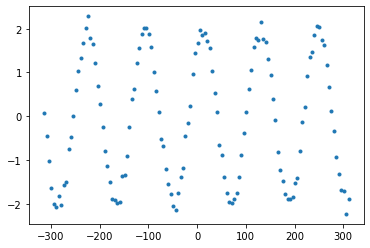

In [2]:
df = pd.read_csv('datos.csv')
X = df['x'].values
Y = df['y'].values

plt.figure()
plt.plot(X,Y,'.')
plt.show()

In [3]:
def objective_function(P,X,Y):
    A, B, C = P[0], P[1], P[2]
    Yp = A*np.sin(B*X+C*np.pi)
    return np.sum(np.abs(Y-Yp))

In [4]:
def draw_solution(P,X,Y):
    A, B, C = P[0], P[1], P[2]
    Yp = A*np.sin(B*X+C*np.pi)
    
    plt.figure()
    plt.plot(X,Y,'.')
    plt.plot(X,Yp)
    plt.show()

10.652452263643578


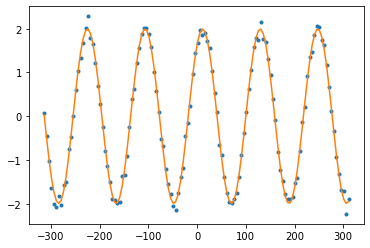

In [5]:
P = [ -1.99390697, -43.9291616 , -96.92022419]
print(objective_function(P,X,Y))
draw_solution(P,X,Y)

# Scipy Differential Evolution

In [6]:
from scipy.optimize import differential_evolution

In [7]:
# P = [Z,B,C]
# f(x) = A*sin(B*x + C*pi)

bounds = [[-10,10],   # A
        [-10,10],     # B
        [-10,10]]     # C

In [8]:
res = differential_evolution(objective_function, bounds, args=(X,Y))
res

     fun: 10.657217451798818
     jac: array([  2.23323974, -20.75167748, -29.24795108])
 message: 'Optimization terminated successfully.'
    nfev: 6762
     nit: 145
 success: True
       x: array([-1.99225068, -3.82306099,  6.69862027])

# Evolutionary Programming

In [9]:
from evolutionary_programming import evolutionary_programming

<class 'evolutionary_programming.EvolutionaryProgramming.Format'>
P = [-1.74308087  8.74685746 -8.54646744  0.45816873  3.40680471  3.32118434]
nit = 50
fun = 93.35162119719368
nfev = 2020


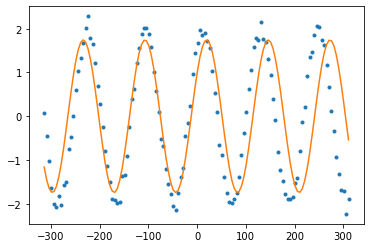

In [10]:
res = evolutionary_programming(objective_function,bounds,args=(X,Y))
print(res)
draw_solution(res.P,X,Y)

# Image Rotation Translation Problem

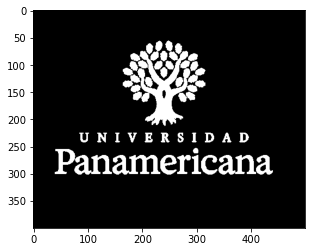

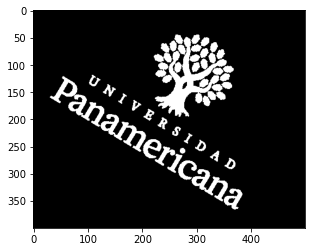

In [11]:
img_obj = cv2.imread('panamericana2.PNG')
img_obj = cv2.cvtColor(img_obj, cv2.COLOR_BGR2GRAY)
img_obj = cv2.bitwise_not(img_obj)
ret, img_obj = cv2.threshold(img_obj,1,255,cv2.THRESH_BINARY)

img_mod = cv2.imread('panamericana1.PNG')
img_mod = cv2.cvtColor(img_mod, cv2.COLOR_BGR2GRAY)
img_mod = cv2.bitwise_not(img_mod)
ret, img_mod = cv2.threshold(img_mod,1,255,cv2.THRESH_BINARY)

modified = np.array(img_mod, dtype=np.uint8)
objective = np.array(img_obj, dtype=np.uint8)
plt.imshow(img_obj, 'gray')
plt.show()
plt.imshow(img_mod, 'gray')
plt.show()


In [12]:
def apply_parameters(individual):
    global img_mod
    global img_obj
    rows, cols = img_obj.shape
    
    transform_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),float(individual[2]),individual[3]) #(rotation center, degrees, scale)
    rotate = cv2.warpAffine(img_mod,transform_matrix,(cols,rows)) # (image, transform matrix, image size)

    transform_matrix = np.float32([[1,0,individual[0]],[0,1,individual[1]]]) #Transform matrix: [[1,0,tx],[1,0,ty]]. tx and ty -> Pixels the image will translate. 
    translate = cv2.warpAffine(rotate,transform_matrix,(cols,rows)) # (image, transform matrix, image size)
    
    return translate.copy()

In [13]:
def f(individual, img_mod, img_obj):    
    rows, cols = img_obj.shape

    transform_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),float(individual[2]),individual[3]) #(rotation center, degrees, scale)
    rotate = cv2.warpAffine(img_mod,transform_matrix,(cols,rows)) # (image, transform matrix, image size)

    transform_matrix = np.float32([[1,0,individual[0]],[0,1,individual[1]]]) #Transform matrix: [[1,0,tx],[1,0,ty]]. tx and ty -> Pixels the image will translate. 
    a = cv2.warpAffine(rotate,transform_matrix,(cols,rows)) # (image, transform matrix, image size)

    ret,new = cv2.threshold(a,1,255,cv2.THRESH_BINARY)
    return -1*f1_score(img_obj, new, average='micro')

In [14]:
rows,cols = img_obj.shape
bounds = [[-cols/10,cols/10],   # tx
        [-rows/10,rows/10],     # ty
        [-180,180],             #angle
        [0.999,1.0001]]     #scale

<class 'evolutionary_programming.EvolutionaryProgramming.Format'>
P = [-1.24241604 21.00726876 31.59757162  1.00141579  4.85890589  1.0894774
  0.70004532  0.00115893]
nit = 60
fun = -0.8656949505465904
nfev = 2420


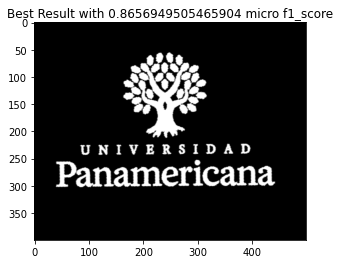

In [16]:
res = evolutionary_programming(f,bounds,60,args=(img_mod, img_obj))
print(res)
final = apply_parameters(res.P)
plt.imshow(final, 'gray')
plt.title("Best Result with "+str(-1*res.fun)+" micro f1_score")
plt.show()